In [404]:
import os
import numpy as np
import pandas as pd
from arcgis import GIS
from arcgis.features import GeoAccessor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt

# show all columns
pd.options.display.max_columns = None

plt.rcParams.update({'figure.figsize': (14.0, 10.0)})
plt.rcParams.update({'font.size': 14})

In [405]:
outputs = r'.\Outputs'
if not os.path.exists(outputs):
    os.makedirs(outputs)

# 1) Data Prep

In [406]:
# read in inputs
b_vars = pd.read_csv(r".\Inputs\run423year2019allbuildings.csv") # building
n_vars = pd.read_csv(r".\Inputs\run423year2019nodevariables.csv") # node
z_vars = pd.read_csv(r".\Inputs\run423year2019zonalvariables.csv") # zone
c_vars = pd.read_csv(r".\Inputs\buildings_for_estimation_grouped_REMM2_v2.csv") # commercial

# rename identical columns
b_vars.rename({'population':'population_b'}, axis=1, inplace=True)
z_vars.rename({'population':'population_z'}, axis=1, inplace=True)

# rename duplicate columns in commercial data
c_vars.rename({'improvement_value':'improvement_value_c', 'non_residential_sqft':'non_residential_sqft_c', 'building_type_id':'building_type_id_c', 'year_built':'year_built_c', 'residential_units':'residential_units_c', 
             'unit_price_residential':'unit_price_residential_c', 'unit_price_non_residential':'unit_price_non_residential_c', 'stories':'stories_c', 'building_sqft':'building_sqft_c'}, axis=1, inplace=True)

# delete unneeded commercial columns
del c_vars['building_id']
del c_vars['X']
del c_vars['Y']

# remove store ids from c_vars
c_vars = c_vars[c_vars['parcel_id'] > 0].copy()
building_ids_c = c_vars['parcel_id'].to_list()


# join utm coords 
parcels = r"E:\REMM\Base_Year_Data_2019\v1\remm_base_year_20220513.gdb\parcels_2019"
parcels = pd.DataFrame.spatial.from_featureclass(parcels)[['parcel_id_REMM', 'x', 'y']].copy()
parcels.columns = ['parcel_id', 'utmxi','utmyi']
b_vars = b_vars.merge(parcels, on='parcel_id', how='left')
del parcels

In [407]:
# check for duplicates
b_vars_names = list(b_vars.columns)
n_vars_names = list(n_vars.columns)
z_vars_names = list(z_vars.columns)
c_vars_names = list(c_vars.columns)

all_names = b_vars_names + n_vars_names + z_vars_names + c_vars_names
seen = set()
dupes = [name for name in all_names if name in seen or seen.add(name)]
print(dupes)   

['node_id', 'zone_id', 'parcel_id']


In [408]:
# combine variables
tbl = b_vars.merge(z_vars, on='zone_id', how='left')
tbl = tbl.merge(n_vars, on='node_id', how='left')

tbl['log1p_fwy_exit_dist_tdm_output'] = np.log1p(tbl['fwy_exit_dist_tdm_output'])
tbl['log1p_rail_stn_dist'] =  np.log1p(tbl['rail_stn_dist'])
tbl['log1p_sqft_per_unit'] =  np.log1p(tbl['sqft_per_unit'])
tbl['log1p_university_dist'] = np.log1p(tbl['university_dist'])
tbl['log1p_real_far'] = np.log1p(tbl['real_far'])
tbl['log1p_building_age'] = np.log1p(tbl['building_age'])

tbl.loc[(tbl['avg_building_age'] < 21), 'avg_building_age_lt_21'] = 1
tbl.loc[~(tbl['avg_building_age'] < 21), 'avg_building_age_lt_21'] = 0

tbl.loc[(tbl['year_built'] < 21), 'year_built_lt_1945'] = 1
tbl.loc[~(tbl['year_built'] < 21), 'year_built_lt_1945'] = 0

In [409]:
# create tables for each county
tbl_57 = tbl[tbl['county_id']==57].copy()
tbl_11 = tbl[tbl['county_id']==11].copy()
tbl_35 = tbl[tbl['county_id']==35].copy()
tbl_49 = tbl[tbl['county_id']==49].copy()

# join the commercial table. NOTE: This will create additional records
tbl = tbl.merge(c_vars, on='parcel_id', how='left')

# create separate commercial table for each county
comm_57 = tbl[(tbl['county_id']==57) & (tbl['parcel_id'].isin(building_ids_c) == True)].copy()
comm_11 = tbl[(tbl['county_id']==11) & (tbl['parcel_id'].isin(building_ids_c) == True)].copy()
comm_35 = tbl[(tbl['county_id']==35) & (tbl['parcel_id'].isin(building_ids_c) == True)].copy()
comm_49 = tbl[(tbl['county_id']==49) & (tbl['parcel_id'].isin(building_ids_c) == True)].copy()

# tbl_57.to_csv(os.path.join(outputs, 'buildings_nodes_zones_57.csv'), index=False)
# tbl_11.to_csv(os.path.join(outputs, 'buildings_nodes_zones_11.csv'), index=False)
# tbl_35.to_csv(os.path.join(outputs, 'buildings_nodes_zones_35.csv'), index=False)
# tbl_49.to_csv(os.path.join(outputs, 'buildings_nodes_zones_49.csv'),index=False)

In [410]:
vars_to_exclude = ['parcel_id', 'building_id', 'note', 'zone_1212']

In [411]:
# drop columns
tbl_57.drop(vars_to_exclude, axis=1, inplace=True)
tbl_11.drop(vars_to_exclude, axis=1, inplace=True)
tbl_35.drop(vars_to_exclude, axis=1, inplace=True)
tbl_49.drop(vars_to_exclude, axis=1, inplace=True)

# 2) Analysis

# Single Family (Residential Unit Price)

###  Weber

In [412]:
# arguments - check these
data = tbl_57
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_1',
             'distmed_2',
             'distmed_3',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'log1p_rail_stn_dist', # np.log1p(rail_stn_dist)
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_university_dist', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age_lt_21',  #I(avg_building_age < 21)[T.True],
             'year_built_lt_1945', #I(year_built < 1945)[T.True]
            ]

In [413]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)]

# get desired columns
sf = sf[old_vars + [y_var]]

# separate independent and dependent variables
x_vars = sf[old_vars].copy()
y_var = sf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:45076


In [414]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.879
Mean Squared Error: 1.888
R-squared scores: 0.986


Text(0.5, 0, 'Random Forest Feature Importance')

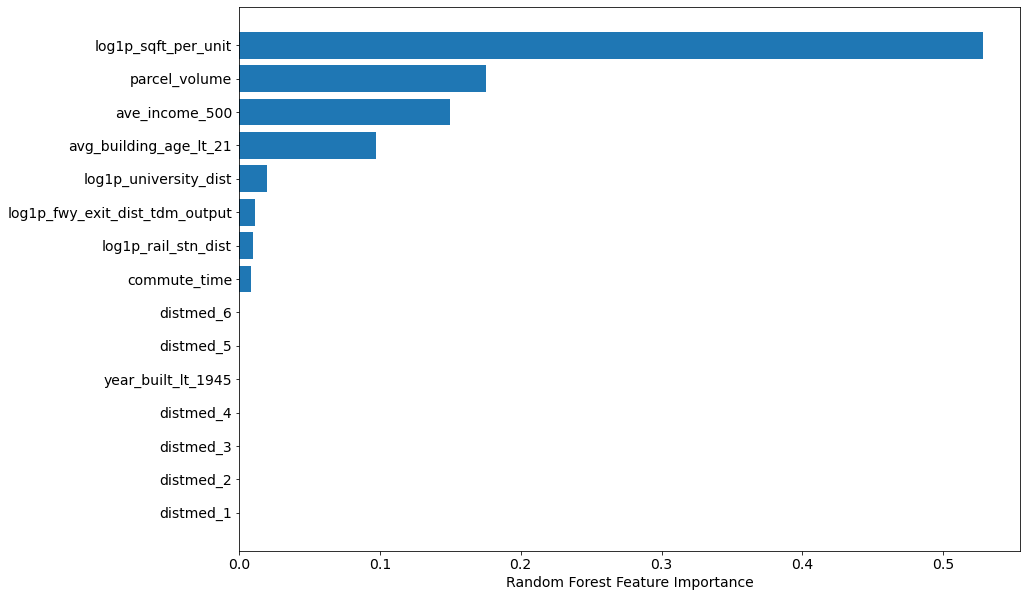

In [415]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Davis

In [416]:
# arguments - check these
data = tbl_11
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_7',
             'distmed_8',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'log1p_rail_stn_dist', # np.log1p(rail_stn_dist)
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_university_dist', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age_lt_21',  #I(avg_building_age < 21)[T.True],
             'year_built_lt_1945', #I(year_built < 1945)[T.True]
            ]

In [417]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)]

# get desired columns
sf = sf[old_vars + [y_var]]

# separate independent and dependent variables
x_vars = sf[old_vars].copy()
y_var = sf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:61584


In [418]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.902
Mean Squared Error: 6.536
R-squared scores: 0.984


Text(0.5, 0, 'Random Forest Feature Importance')

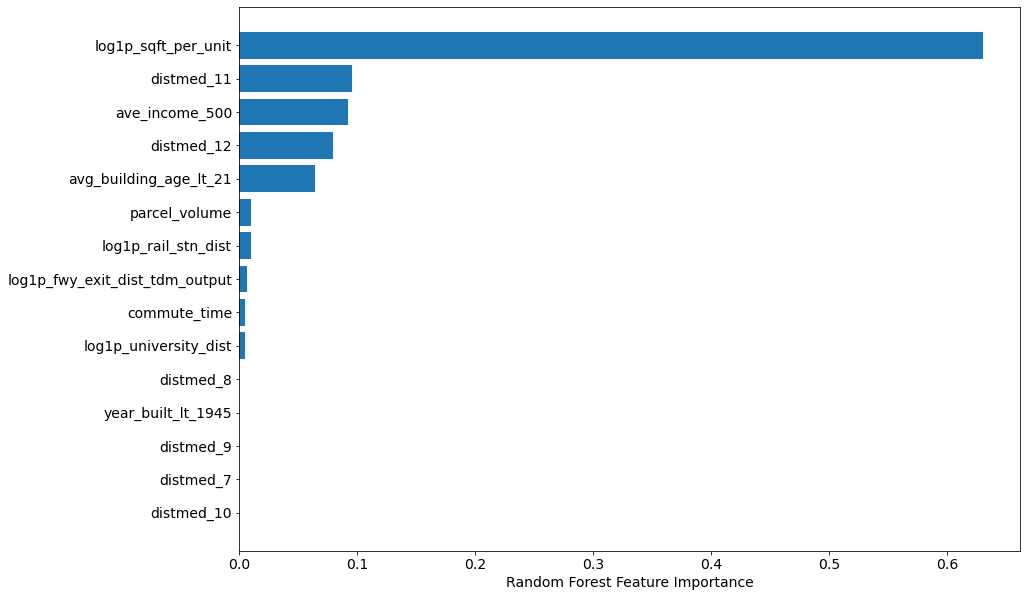

In [419]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [420]:
# arguments - check these
data = tbl_35
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_13',
             'distmed_14',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_23',
             'distmed_24',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'log1p_rail_stn_dist', # np.log1p(rail_stn_dist)
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_university_dist', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age_lt_21',  #I(avg_building_age < 21)[T.True],
             'year_built_lt_1945', #I(year_built < 1945)[T.True]
            ]

In [421]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)]

# get desired columns
sf = sf[old_vars + [y_var]]

# separate independent and dependent variables
x_vars = sf[old_vars].copy()
y_var = sf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:176217


In [422]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.43
Mean Squared Error: 2.789
R-squared scores: 0.988


Text(0.5, 0, 'Random Forest Feature Importance')

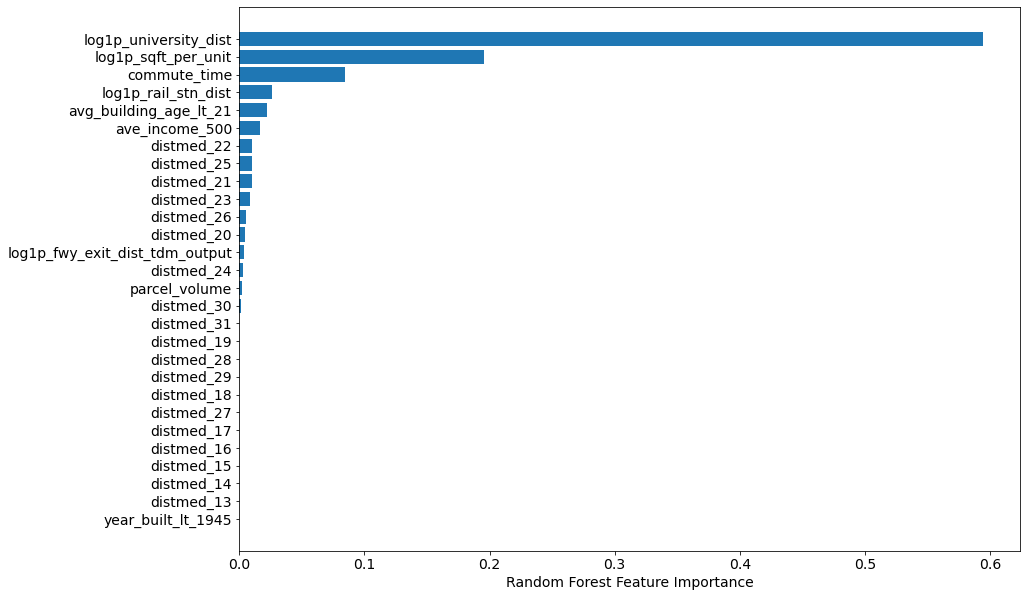

In [423]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [424]:
# arguments - check these
data = tbl_49
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_38',
             'distmed_39',
             'distmed_40',
             'distmed_41',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'log1p_rail_stn_dist', # np.log1p(rail_stn_dist)
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_university_dist', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age_lt_21',  #I(avg_building_age < 21)[T.True],
             'year_built_lt_1945', #I(year_built < 1945)[T.True]
            ]

In [425]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)]

# get desired columns
sf = sf[old_vars + [y_var]]

# separate independent and dependent variables
x_vars = sf[old_vars].copy()
y_var = sf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:92187


In [426]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.387
Mean Squared Error: 4.198
R-squared scores: 0.947


Text(0.5, 0, 'Random Forest Feature Importance')

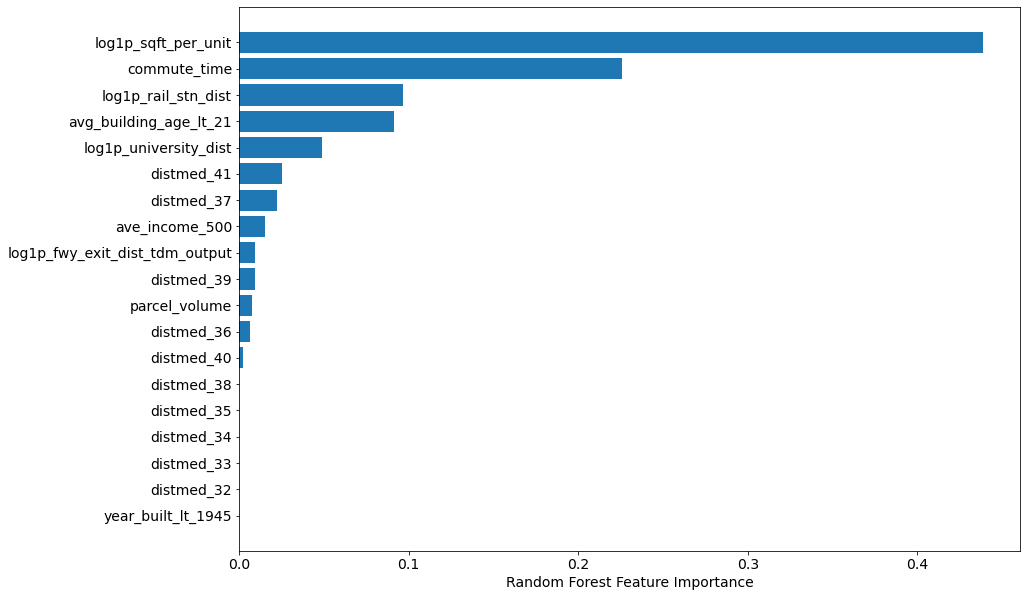

In [427]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Multifamily (Residential Unit Price)

###  Weber

In [428]:
# arguments - check these
data = tbl_57
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_1',
             'distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_14',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_2',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_23',
             'distmed_24',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_3',
             'distmed_30',
             'distmed_31',
             'distmed_36',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_8',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'mfdu_500',
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [429]:
# filters
mf = data[(data['building_type_id'] == 2) & (data['res_price_per_sqft'] > 0)].copy()

# get desired columns
mf = mf[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = mf[old_vars].copy()
y_var = mf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:2002


In [430]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 2.276
Mean Squared Error: 38.807
R-squared scores: 0.871


Text(0.5, 0, 'Random Forest Feature Importance')

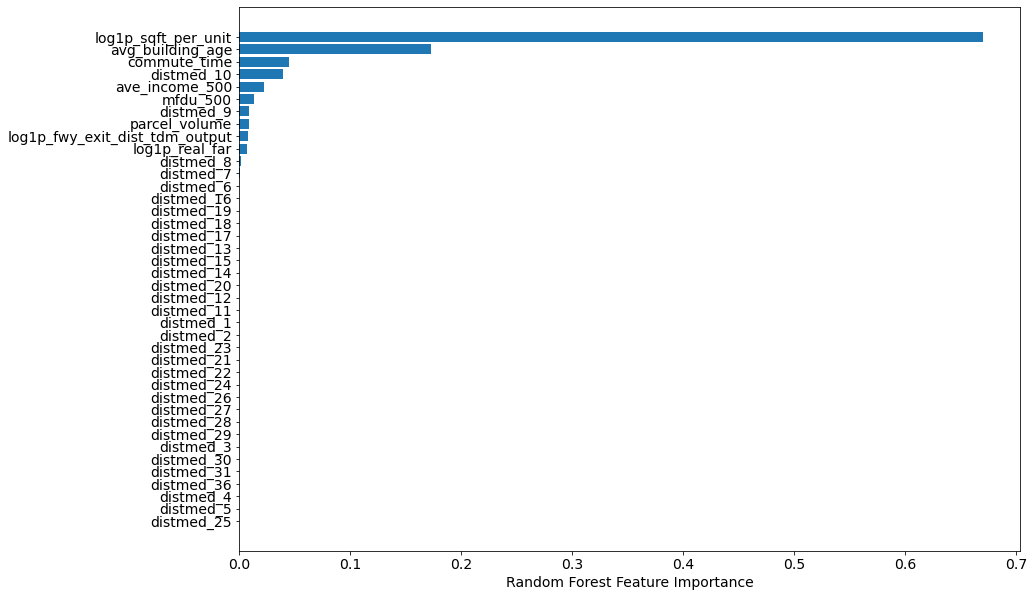

In [431]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Davis

In [432]:
# arguments - check these
data = tbl_11
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_1',
             'distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_14',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_2',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_23',
             'distmed_24',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_3',
             'distmed_30',
             'distmed_31',
             'distmed_36',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_8',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'mfdu_500',
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [433]:
# filters
mf = data[(data['building_type_id'] == 2) & (data['res_price_per_sqft'] > 0)].copy()

# get desired columns
mf = mf[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = mf[old_vars].copy()
y_var = mf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:1565


In [434]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 3.419
Mean Squared Error: 132.24
R-squared scores: 0.686


Text(0.5, 0, 'Random Forest Feature Importance')

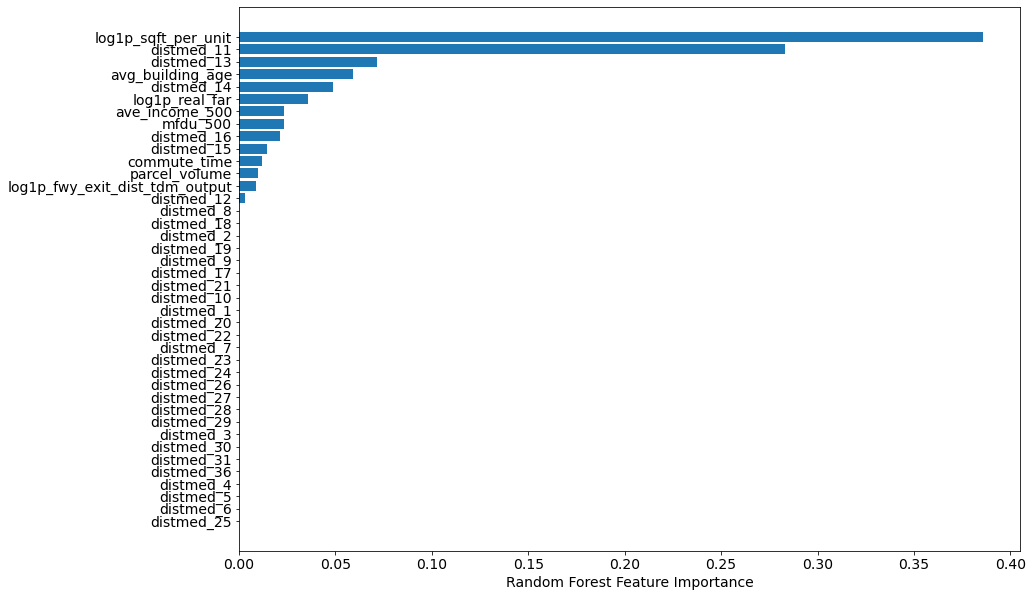

In [435]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [436]:
# arguments - check these
data = tbl_35
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_1',
             'distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_14',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_2',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_23',
             'distmed_24',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_3',
             'distmed_30',
             'distmed_31',
             'distmed_36',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_8',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'mfdu_500',
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [437]:
# filters
mf = data[(data['building_type_id'] == 2) & (data['res_price_per_sqft'] > 0)].copy()

# get desired columns
mf = mf[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = mf[old_vars].copy()
y_var = mf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:8314


In [438]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 2.493
Mean Squared Error: 57.747
R-squared scores: 0.904


Text(0.5, 0, 'Random Forest Feature Importance')

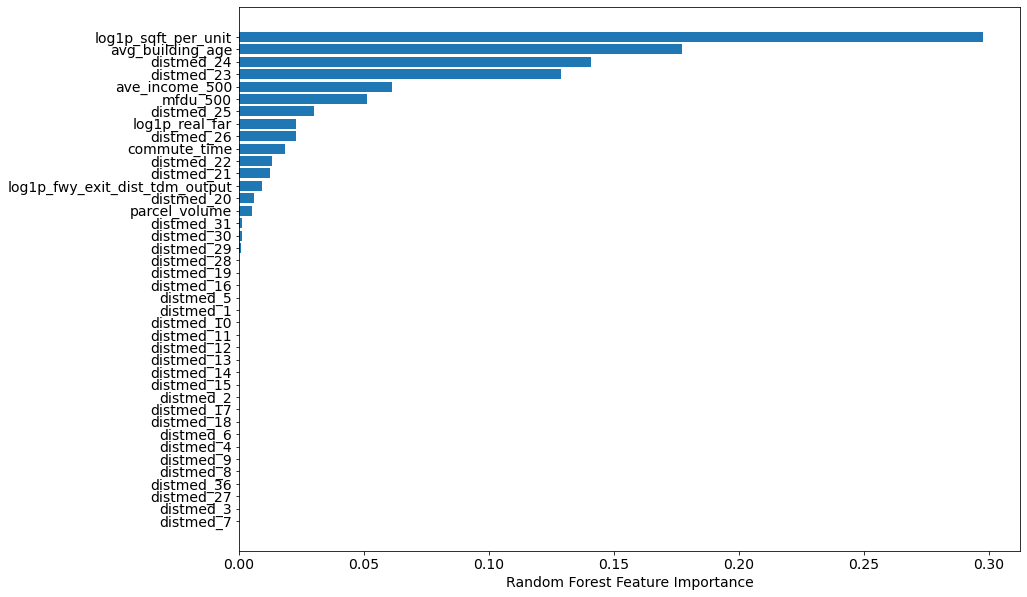

In [439]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [440]:
# arguments - check these
data = tbl_49
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_1',
             'distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_14',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_2',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_23',
             'distmed_24',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_3',
             'distmed_30',
             'distmed_31',
             'distmed_36',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_8',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'mfdu_500',
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [441]:
# filters
mf = data[(data['building_type_id'] == 2) & (data['res_price_per_sqft'] > 0)].copy()

# get desired columns
mf = mf[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = mf[old_vars].copy()
y_var = mf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:8399


In [442]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 1.076
Mean Squared Error: 7.55
R-squared scores: 0.968


Text(0.5, 0, 'Random Forest Feature Importance')

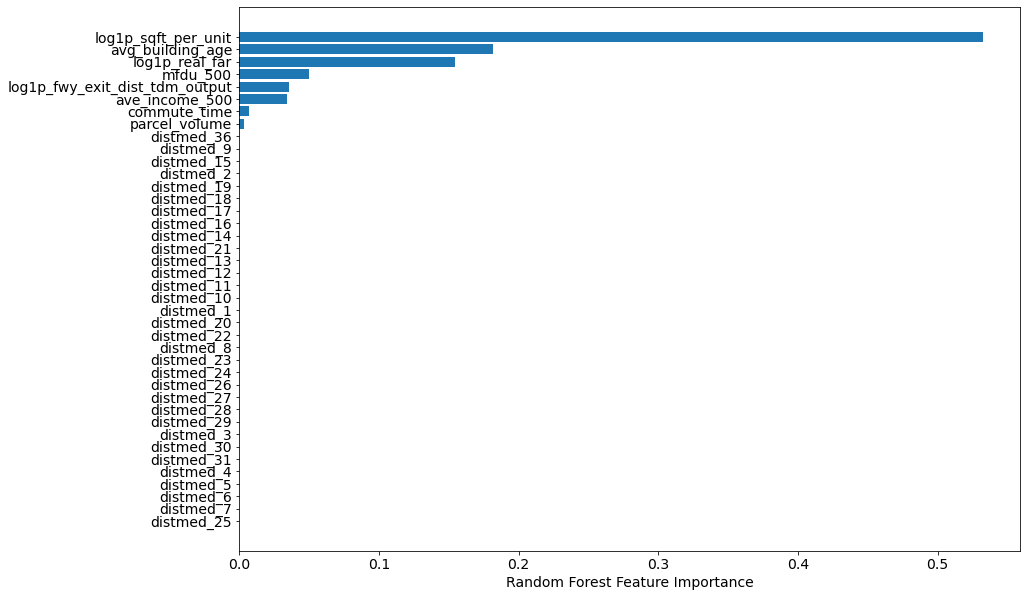

In [443]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Retail

###  Weber & Davis

In [444]:
# arguments - check these
data = pd.concat([comm_57, comm_11])
y_var = 'unit_price_non_residential_c'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_38',
             'distmed_39',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'jobs_1_500',
             'jobs_7_500',
             'train_stn_500',
             'log1p_real_far',
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [445]:
# filters
ret = data[(data['building_type_id_c'] == 4) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
ret = ret[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = ret[old_vars].copy()
y_var = ret[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:156


In [446]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 1789290.535
Mean Squared Error: 47310942957302.23
R-squared scores: -0.033


Text(0.5, 0, 'Random Forest Feature Importance')

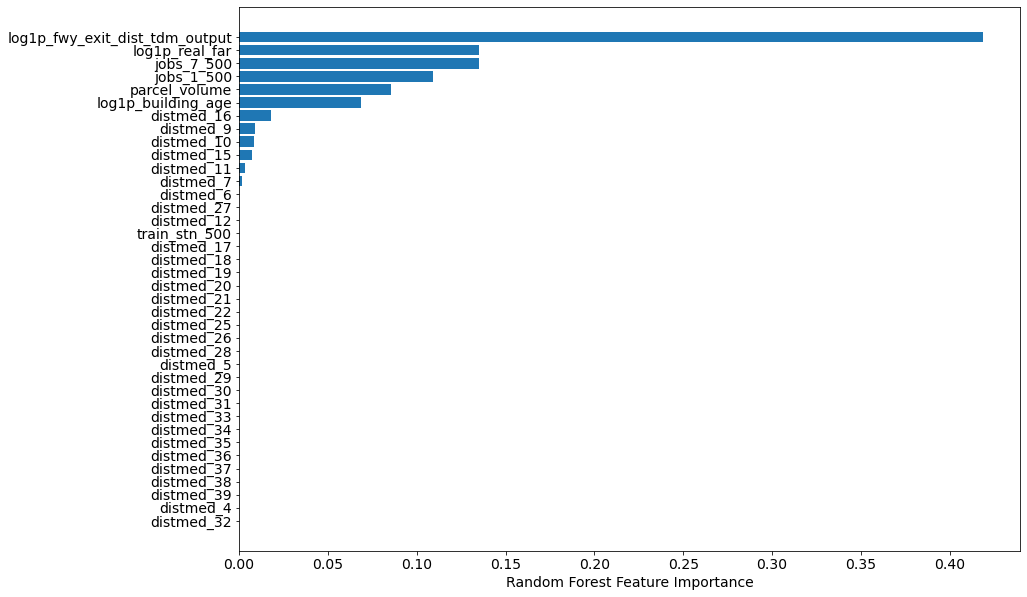

In [447]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [448]:
# arguments - check these
data = comm_35
y_var = 'unit_price_non_residential_c'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_38',
             'distmed_39',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'jobs_1_500',
             'jobs_7_500',
             'train_stn_500',
             'log1p_real_far',
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [449]:
# filters
ret = data[(data['building_type_id_c'] == 4) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
ret = ret[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = ret[old_vars].copy()
y_var = ret[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:480


In [450]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 2417699.271
Mean Squared Error: 23013806550577.6
R-squared scores: 0.539


Text(0.5, 0, 'Random Forest Feature Importance')

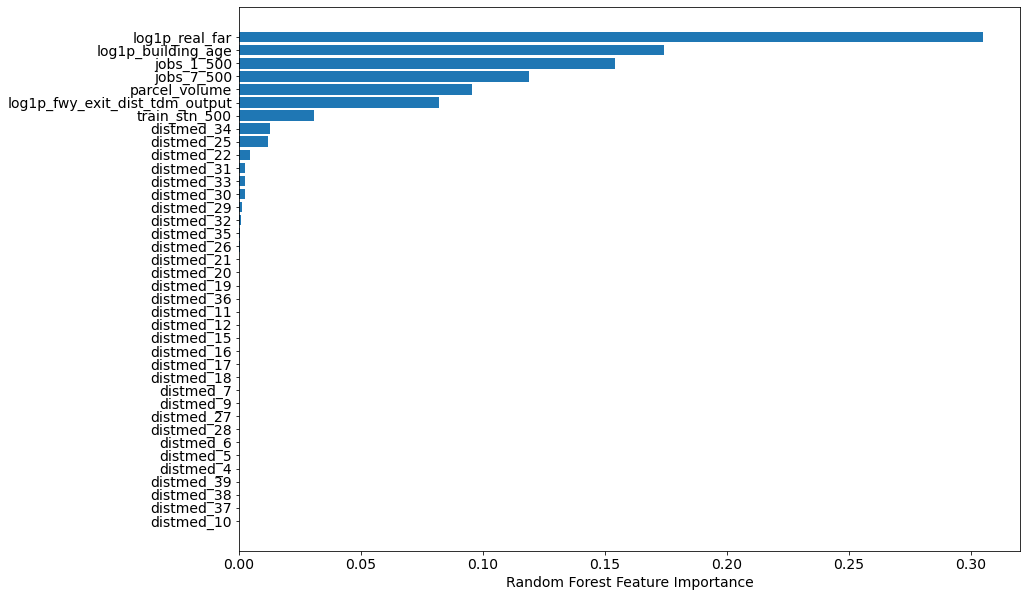

In [451]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [452]:
# arguments - check these
data = comm_49
y_var = 'unit_price_non_residential_c'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_38',
             'distmed_39',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'jobs_1_500',
             'jobs_7_500',
             'train_stn_500',
             'log1p_real_far',
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [453]:
# filters
ret = data[(data['building_type_id_c'] == 4) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
ret = ret[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = ret[old_vars].copy()
y_var = ret[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:204


In [454]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 736680.349
Mean Squared Error: 1518297620633.826
R-squared scores: 0.878


Text(0.5, 0, 'Random Forest Feature Importance')

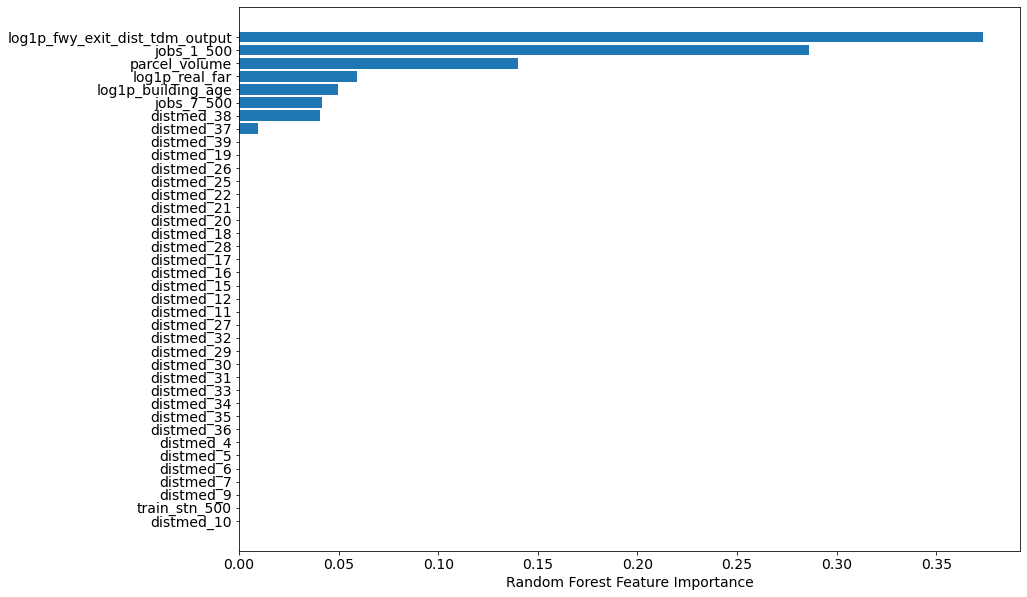

In [455]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Office

###  Weber & Davis

In [456]:
# arguments - check these
data = pd.concat([comm_57, comm_11])
y_var = 'unit_price_non_residential_c'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_6',
             'distmed_8',
             'distmed_9',
             'land_value_per_acre',
             'logsum_hhinc4',
             'median_income',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'jobs_6_500',
             'log1p_real_far',
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [457]:
# filters
off = data[(data['building_type_id_c'] == 5) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
off = off[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = off[old_vars].copy()
y_var = off[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:162


In [458]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 153728.254
Mean Squared Error: 60438609911.41
R-squared scores: 0.517


Text(0.5, 0, 'Random Forest Feature Importance')

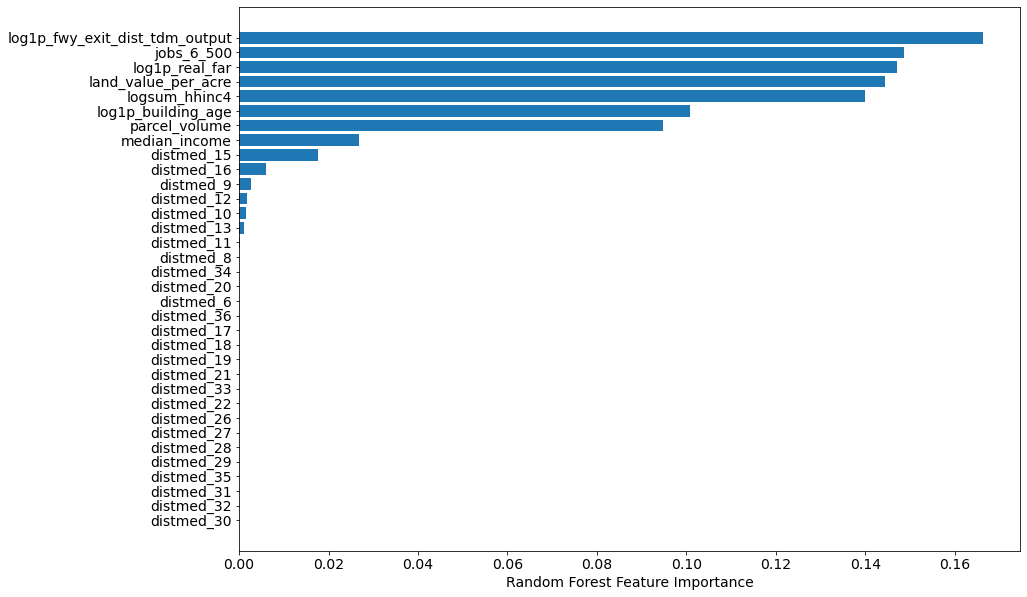

In [459]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [460]:
# arguments - check these
data = comm_35
y_var = 'unit_price_non_residential_c'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_6',
             'distmed_8',
             'distmed_9',
             'land_value_per_acre',
             'logsum_hhinc4',
             'median_income',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'jobs_6_500',
             'log1p_real_far',
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [461]:
# filters
off = data[(data['building_type_id_c'] == 5) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
off = off[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = off[old_vars].copy()
y_var = off[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:697


In [462]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 508864.793
Mean Squared Error: 1014647809575.6
R-squared scores: 0.9


Text(0.5, 0, 'Random Forest Feature Importance')

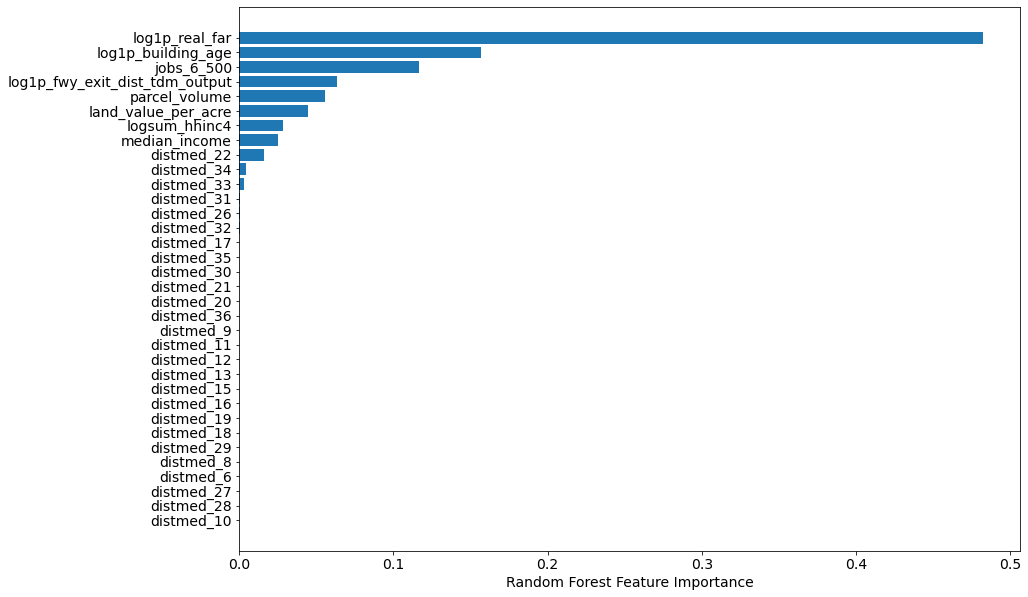

In [463]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [464]:
# arguments - check these
data = comm_49
y_var = 'unit_price_non_residential_c'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_6',
             'distmed_8',
             'distmed_9',
             'land_value_per_acre',
             'logsum_hhinc4',
             'median_income',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'jobs_6_500',
             'log1p_real_far',
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [465]:
# filters
off = data[(data['building_type_id_c'] == 5) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
off = off[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = off[old_vars].copy()
y_var = off[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:212


In [466]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 908498.163
Mean Squared Error: 23815473264671.73
R-squared scores: 0.145


Text(0.5, 0, 'Random Forest Feature Importance')

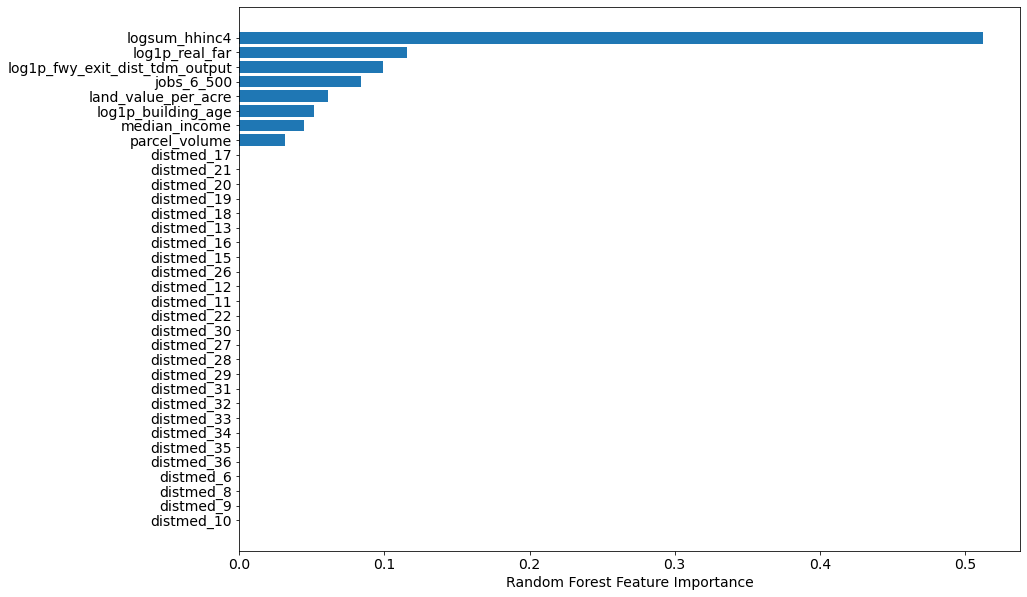

In [467]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Industrial

###  Weber & Davis

In [468]:
# arguments - check these
data = pd.concat([comm_57, comm_11])
y_var = 'unit_price_non_residential_c'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_9',
             'industrial_sqft_1000',
             'jobs_6_1000',
             'jobs_8_1000',
             'mfdu_1000',   #np.log1p(fwy_exit_dist_tdm_output)
             'rail_depot',
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [469]:
# filters
ind = data[(data['building_type_id_c'] == 3) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
ind = ind[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = ind[old_vars].copy()
y_var = ind[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:137


In [470]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 60746.014
Mean Squared Error: 8494330901.339
R-squared scores: 0.814


Text(0.5, 0, 'Random Forest Feature Importance')

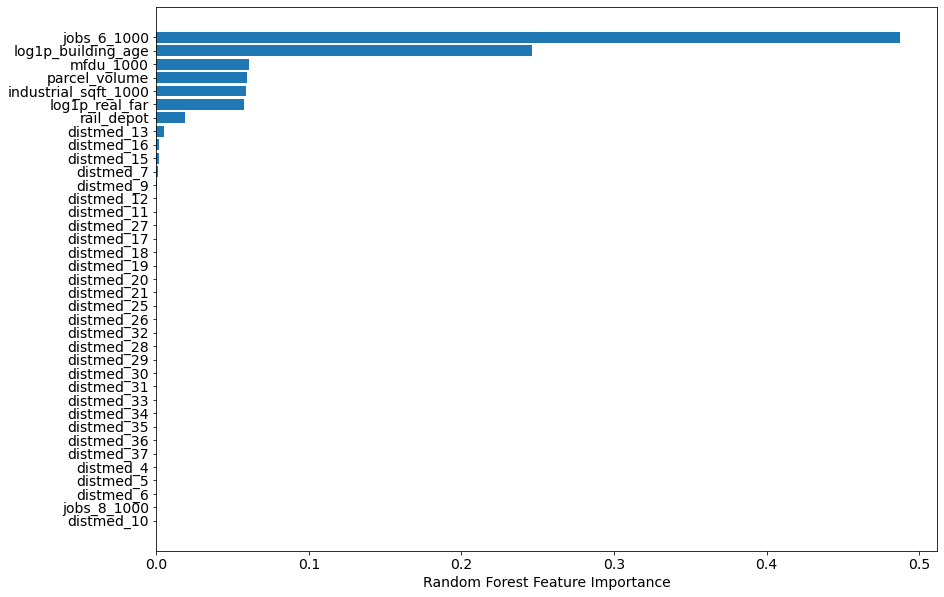

In [471]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [472]:
# arguments - check these
data = comm_35
y_var = 'unit_price_non_residential_c'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_9',
             'industrial_sqft_1000',
             'jobs_6_1000',
             'jobs_8_1000',
             'mfdu_1000',   #np.log1p(fwy_exit_dist_tdm_output)
             'rail_depot',
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [473]:
# filters
ind = data[(data['building_type_id_c'] == 3) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
ind = ind[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = ind[old_vars].copy()
y_var = ind[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:675


In [474]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 290589.159
Mean Squared Error: 1460261892968.508
R-squared scores: -5.713


Text(0.5, 0, 'Random Forest Feature Importance')

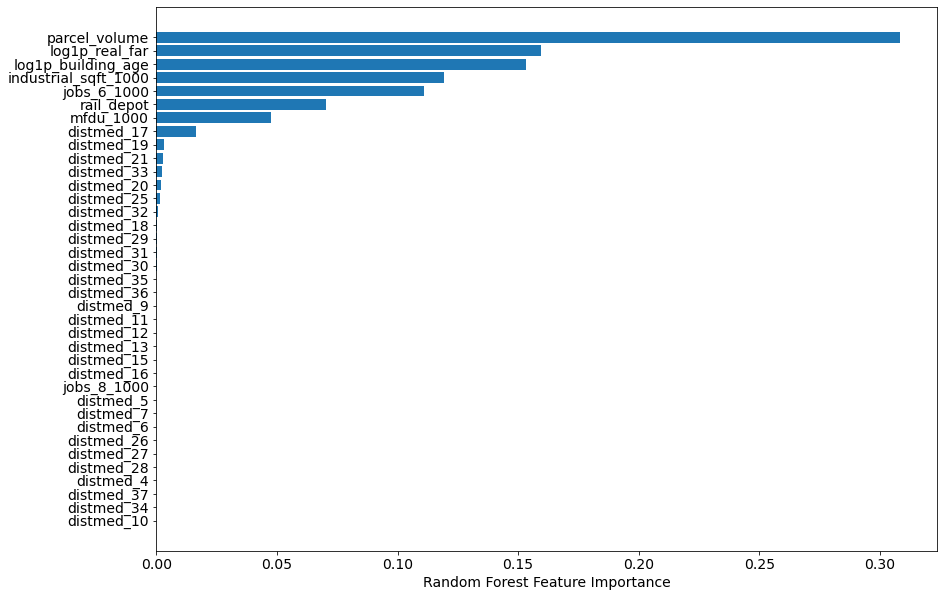

In [475]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [476]:
# arguments - check these
data = comm_49
y_var = 'unit_price_non_residential_c'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_9',
             'industrial_sqft_1000',
             'jobs_6_1000',
             'jobs_8_1000',
             'mfdu_1000',   #np.log1p(fwy_exit_dist_tdm_output)
             'rail_depot',
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [477]:
# filters
ind = data[(data['building_type_id_c'] == 5) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
ind = ind[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = ind[old_vars].copy()
y_var = ind[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:212


In [478]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 871663.803
Mean Squared Error: 23714664722241.06
R-squared scores: 0.148


Text(0.5, 0, 'Random Forest Feature Importance')

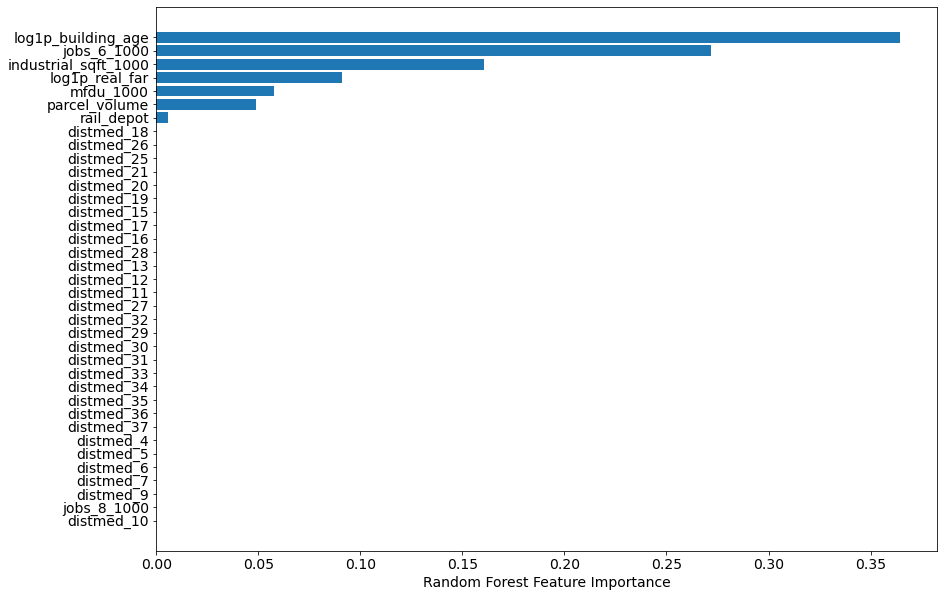

In [479]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")